In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
# 加载所有必要数据集
orders = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_orders_dataset.csv')
customers = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_customers_dataset.csv')
reviews = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_order_reviews_dataset.csv')
items = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_order_items_dataset.csv')
sellers = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_sellers_dataset.csv')
products = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/olist_products_dataset.csv')
translation = pd.read_csv('https://raw.githubusercontent.com/JamesLo94/schulich_data_science/main/Olist/product_category_name_translation.csv')

In [ ]:
# Translate category names
products = products.merge(translation, on='product_category_name', how='left')

In [7]:
# 2. DATA MERGING
# ==============
merged = (
    orders.merge(customers, on='customer_id')
    .merge(reviews, on='order_id')
    .merge(items, on='order_id')
    .merge(sellers, on='seller_id')
    .merge(products, on='product_id'))

In [9]:
# 3. DATA PREPARATION
# ===================
# Filter for furniture/home decor
print("\nFiltering furniture/decor products...")
furniture_categories = ['moveis_decoracao', 'moveis_sala', 'moveis_quarto']  # 使用原始葡萄牙语类别名
furniture_data = merged[merged['product_category_name'].isin(furniture_categories)]


Filtering furniture/decor products...


In [11]:
# Convert dates
date_cols = ['order_purchase_timestamp', 'order_delivered_customer_date']
for col in date_cols:
    furniture_data[col] = pd.to_datetime(furniture_data[col])

# Calculate delivery speed (in days)
furniture_data['delivery_speed'] = (
    furniture_data['order_delivered_customer_date'] - 
    furniture_data['order_purchase_timestamp']
).dt.days

# Remove outliers (deliveries <0 or >60 days)
furniture_data = furniture_data[
    (furniture_data['delivery_speed'] > 0) & 
    (furniture_data['delivery_speed'] < 60)
]

# Fill missing reviews with median
furniture_data['review_score'] = furniture_data['review_score'].fillna(
    furniture_data['review_score'].median())

C:\Users\q\AppData\Local\Temp\ipykernel_26036\3690459281.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  furniture_data[col] = pd.to_datetime(furniture_data[col])
C:\Users\q\AppData\Local\Temp\ipykernel_26036\3690459281.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  furniture_data[col] = pd.to_datetime(furniture_data[col])
C:\Users\q\AppData\Local\Temp\ipykernel_26036\3690459281.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [12]:
# 4. EDA
# ==============
print("\nRunning exploratory analysis...")
plt.figure(figsize=(12,5))


Running exploratory analysis...


<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

Text(0.5, 1.0, 'Furniture Delivery Speed Distribution')

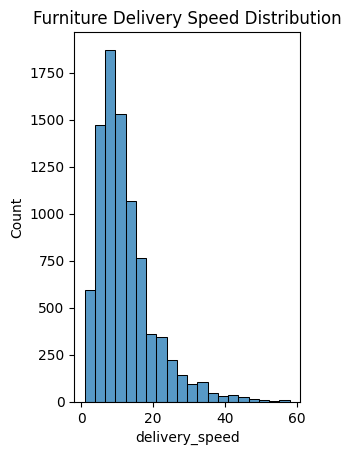

In [13]:
# Delivery speed distribution
plt.subplot(1,2,1)
sns.histplot(furniture_data['delivery_speed'], bins=20)
plt.title("Furniture Delivery Speed Distribution")

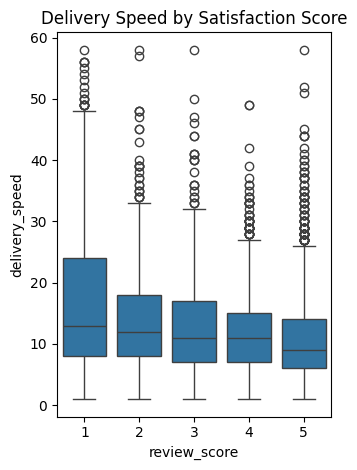

In [14]:
# Delivery speed vs Satisfaction
plt.subplot(1,2,2)
sns.boxplot(x='review_score', y='delivery_speed', data=furniture_data)
plt.title("Delivery Speed by Satisfaction Score")
plt.tight_layout()
plt.show()

In [15]:
# Calculate correlation
delivery_corr = furniture_data['delivery_speed'].corr(furniture_data['review_score'])
print(f"\nCorrelation between delivery speed and satisfaction: {delivery_corr:.3f}")


Correlation between delivery speed and satisfaction: -0.260


In [16]:
# 5. EXPERIMENT DESIGN
# ===================
print("\nDesigning experiment...")

# Create seller-level delivery performance
seller_stats = furniture_data.groupby('seller_id').agg(
    avg_delivery_speed=('delivery_speed', 'mean'),
    order_count=('order_id', 'nunique')
).reset_index()


Designing experiment...


In [18]:
# Only sellers with >=5 furniture orders
qualified_sellers = seller_stats[seller_stats['order_count'] >=5]

# Merge back to main data
furniture_data = furniture_data.merge(
    qualified_sellers[['seller_id', 'avg_delivery_speed']], 
    on='seller_id')

In [19]:
# Random assignment
np.random.seed(42)
furniture_data['group'] = np.random.choice(
    ['test', 'control'], 
    size=len(furniture_data),
    p=[0.5, 0.5]
)

In [20]:
# Define test group: top 20% fastest sellers
speed_threshold = furniture_data['avg_delivery_speed'].quantile(0.2)
furniture_data['fast_seller'] = furniture_data['avg_delivery_speed'] <= speed_threshold

In [21]:
# 6. BALANCE CHECK
# ========================
print("\nChecking group balance...")
balance_vars = ['price', 'product_weight_g', 'product_photos_qty']
balance_results = []

for var in balance_vars:
    test_mean = furniture_data[furniture_data['group']=='test'][var].mean()
    control_mean = furniture_data[furniture_data['group']=='control'][var].mean()
    t_stat, p_val = stats.ttest_ind(
        furniture_data[furniture_data['group']=='test'][var],
        furniture_data[furniture_data['group']=='control'][var],
        equal_var=False
    )
    balance_results.append({
        'variable': var,
        'test_mean': test_mean,
        'control_mean': control_mean,
        'p_value': p_val
    })

print(pd.DataFrame(balance_results))


Checking group balance...
             variable    test_mean  control_mean   p_value
0               price    89.757946     88.363591  0.473218
1    product_weight_g  2994.267537   2918.948451  0.398807
2  product_photos_qty     2.494194      2.444857  0.257740


In [22]:
# 7. EXPERIMENT ANALYSIS
# ========================
print("\nAnalyzing results...")

# Compare satisfaction scores
test_scores = furniture_data[furniture_data['group']=='test']['review_score']
control_scores = furniture_data[furniture_data['group']=='control']['review_score']

print(f"Test group satisfaction: {test_scores.mean():.2f}")
print(f"Control group satisfaction: {control_scores.mean():.2f}")

t_stat, p_val = stats.ttest_ind(test_scores, control_scores)
print(f"Difference: {test_scores.mean()-control_scores.mean():.2f}")
print(f"p-value: {p_val:.4f}")


Analyzing results...
Test group satisfaction: 3.98
Control group satisfaction: 3.94
Difference: 0.04
p-value: 0.1756


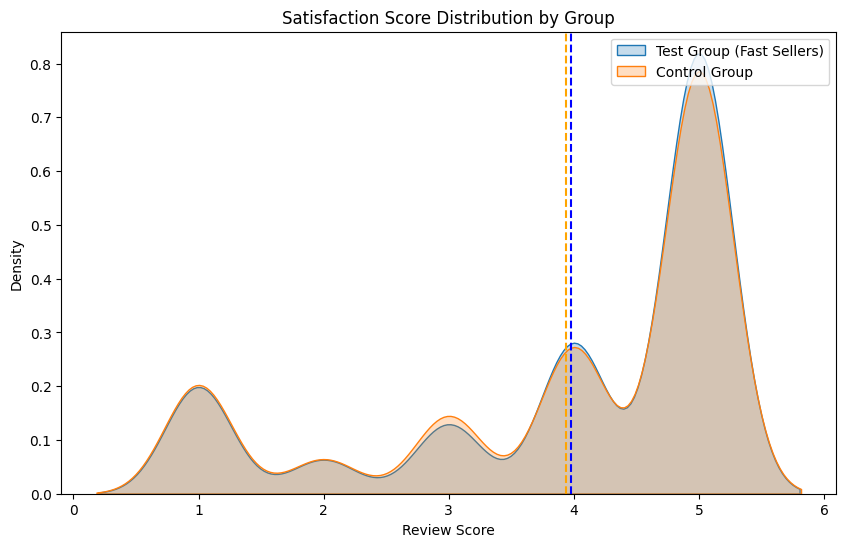

In [23]:
# Visualization
plt.figure(figsize=(10,6))
sns.kdeplot(test_scores, label='Test Group (Fast Sellers)', fill=True)
sns.kdeplot(control_scores, label='Control Group', fill=True)
plt.axvline(x=test_scores.mean(), color='blue', linestyle='--')
plt.axvline(x=control_scores.mean(), color='orange', linestyle='--')
plt.title("Satisfaction Score Distribution by Group")
plt.xlabel("Review Score")
plt.legend()
plt.show()

In [24]:
# 8. ADDITIONAL METRICS
# ========================
# Check if fast sellers actually performed better
fast_seller_scores = furniture_data[
    (furniture_data['group']=='test') & 
    (furniture_data['fast_seller'])
]['review_score']

other_sellers_scores = furniture_data[
    (furniture_data['group']=='test') & 
    (~furniture_data['fast_seller'])
]['review_score']

print(f"\nFast sellers satisfaction: {fast_seller_scores.mean():.2f}")
print(f"Other sellers satisfaction: {other_sellers_scores.mean():.2f}")


Fast sellers satisfaction: 4.16
Other sellers satisfaction: 3.93


In [26]:
furniture_data.groupby(pd.cut(furniture_data['delivery_speed'], 
                       bins=[0,7,14,60]))['review_score'].mean()

delivery_speed
(0, 7]      4.163035
(7, 14]     4.058428
(14, 60]    3.589700
Name: review_score, dtype: float64